In [8]:
import pandas as pd
import numpy as np 

In [9]:
df = pd.read_csv("../../resources/additional_data/CrPVD29N-vs-WTgrowthcurve.csv")

In [10]:
df['sample_id'] = df['genotype'] + df['rep'] +df['variant']

In [11]:
df['value'] = df['2^(-ΔCT)']

In [12]:
df['value_trans'] = np.log(df['value'])

In [13]:
df[df['hpi']==0]

,genotype,rep,variant,hpi,fold_change,2^(-ΔCT),sample_id,value,value_trans
0,WT,a,P0,0,0.693595,0.000007,WTaP0,0.000007,-11.921310
7,WT,b,P0,0,0.505217,0.000005,WTbP0,0.000005,-12.238212
14,WT,c,P0,0,2.853754,0.000027,WTcP0,0.000027,-10.506809
21,KO,a,P0,0,0.693595,0.000007,KOaP0,0.000007,-11.920894
28,KO,b,P0,0,0.505217,0.000005,KObP0,0.000005,-12.238212
35,KO,c,P0,0,2.853754,0.000027,KOcP0,0.000027,-10.506809
42,IP,a,P0,0,0.693595,0.000007,IPaP0,0.000007,-11.921310
49,IP,b,P0,0,0.505217,0.000005,IPbP0,0.000005,-12.238212
56,IP,c,P0,0,2.853754,0.000027,IPcP0,0.000027,-10.506809
63,WT,a,D29N,0,2.140776,0.000030,WTaD29N,0.000030,-10.419001


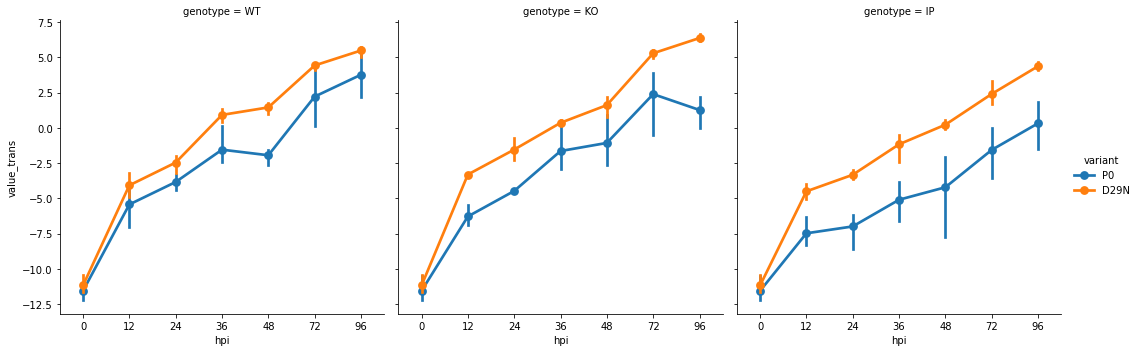

In [14]:
import seaborn as sns
g = sns.catplot(df,
kind='point',
x='hpi',
#row='rep',
y='value_trans',
hue='variant',
col='genotype')

In [32]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [33]:
%%R -i df 

#library(lme4)
library(lmerTest)
library(rstatix)
library(ggpubr)
library(ggplot2)
library(ggdist) #for stat halfeye
library(DHARMa) #THE STAR OF THE SHOW INTERPRETATION OF MODEL FIT
library(MASS)


/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


In [34]:
%%R

# Convert genotype to factor
df$genotype <- factor(df$genotype)
# Relevel the genotype factor with W as reference
df$genotype <- relevel(df$genotype, ref = "WT")

df$variant <- factor(df$variant)
df$variant <- relevel(df$variant, ref = "P0")


In [23]:
%%R 

lmm_model <- lmer(value_trans ~ hpi + variant * genotype+ (1 | sample_id) ,
                  data = df)

summary(lmm_model)



R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: value_trans ~ hpi + variant * genotype + (1 | sample_id)
   Data: df

REML criterion at convergence: 548.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5731 -0.5412  0.3348  0.6556  1.8206 

Random effects:
 Groups    Name        Variance Std.Dev.
 sample_id (Intercept) 0.000    0.00    
 Residual              4.579    2.14    
Number of obs: 126, groups:  sample_id, 18

Fixed effects:
                         Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)             -8.373364   0.529841 119.000000 -15.804  < 2e-16 ***
hpi                      0.139843   0.006085 119.000000  22.982  < 2e-16 ***
variantD29N              1.842944   0.660388 119.000000   2.791 0.006128 ** 
genotypeIP              -2.605480   0.660388 119.000000  -3.945 0.000135 ***
genotypeKO              -0.433283   0.660388 119.000000  -0.656 0.513024    
variantD29N:genotypeIP   1.499716  

In [35]:
%%R 

model_simple <- lm(value_trans ~ hpi + variant + genotype,
                  data = df)

summary(model_simple)


Call:
lm(formula = value_trans ~ hpi + variant + genotype, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4672 -1.1313  0.6041  1.3836  3.8778 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -8.7677780  0.4572491 -19.175  < 2e-16 ***
hpi          0.1398428  0.0060999  22.925  < 2e-16 ***
variantD29N  2.6317707  0.3822189   6.886 2.75e-10 ***
genotypeIP  -1.8556223  0.4681206  -3.964 0.000125 ***
genotypeKO   0.0000994  0.4681206   0.000 0.999831    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.145 on 121 degrees of freedom
Multiple R-squared:  0.8308,	Adjusted R-squared:  0.8252 
F-statistic: 148.5 on 4 and 121 DF,  p-value: < 2.2e-16



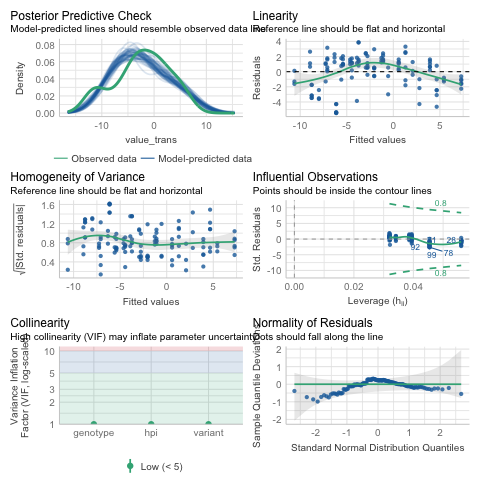

In [31]:
%%R 

# Check model assumptions
library(performance)
check_model(model_simple)
